In [1]:
options(repr.plot.width=12, repr.plot.height=9)


In [2]:
library(tidyverse)
library(sf)
library(spData)


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.9.0, GDAL 3.2.2, PROJ 7.2.1; sf_use_s2() is TRUE



### Continuing the PAD example



In [3]:
pad_mds <- read_csv("data/pad_mds.csv") %>%
    st_as_sf(coords = c("LONGITUDE", "LATITUDE"))

pad_mds %>%
    slice_head(n=10)

Rows: 183 Columns: 7

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): doculect, col
dbl (5): LONGITUDE, LATITUDE, r, g, b


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



doculect,col,r,g,b,geometry
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<POINT>
Docelles,#E180A4,0.8819625,0.5008112,0.64290518,POINT (6.61615 48.14471)
Schachach,#DF9114,0.8751002,0.5677925,0.07852466,POINT (11.40528 48.46679)
Pielenhofen,#DFA206,0.8729309,0.6366345,0.02257775,POINT (11.95648 49.07279)
Oberviehbach,#DC9F09,0.8626297,0.6244695,0.03554154,POINT (12.37579 48.58109)
Maibrunn,#8D473F,0.5531598,0.2803814,0.24840166,POINT (12.7814 49.016)
Hartenstein,#D0980E,0.8170172,0.5974103,0.05424797,POINT (11.52376 49.59651)
Langenbruck,#D79805,0.8443453,0.5952431,0.01832458,POINT (11.51153 48.6382)
Gelting,#E29F11,0.8859810,0.6218752,0.06470765,POINT (11.81097 48.19687)
Pöttmes,#E0A70A,0.8791276,0.6555337,0.04086412,POINT (11.09074 48.58242)


The same workflow gives us a Voronoi tesselation of the PAD locations.

In [4]:
pad_voronoi <- pad_mds %>%
    st_coordinates() %>% 
    st_multipoint() %>%
    st_voronoi() %>%
    lapply(function(x) x) %>%
    st_sfc() %>%
    st_sf(geometry = .) %>%
    st_join(pad_mds) 

In [5]:
pad_voronoi %>%
    st_crs()

Coordinate Reference System: NA

In [6]:
st_crs(pad_voronoi) <- 4326

In [7]:
(bb_pad = st_bbox(pad_mds))

    xmin     ymin     xmax     ymax 
 6.08842 47.44684 14.85208 54.72756 

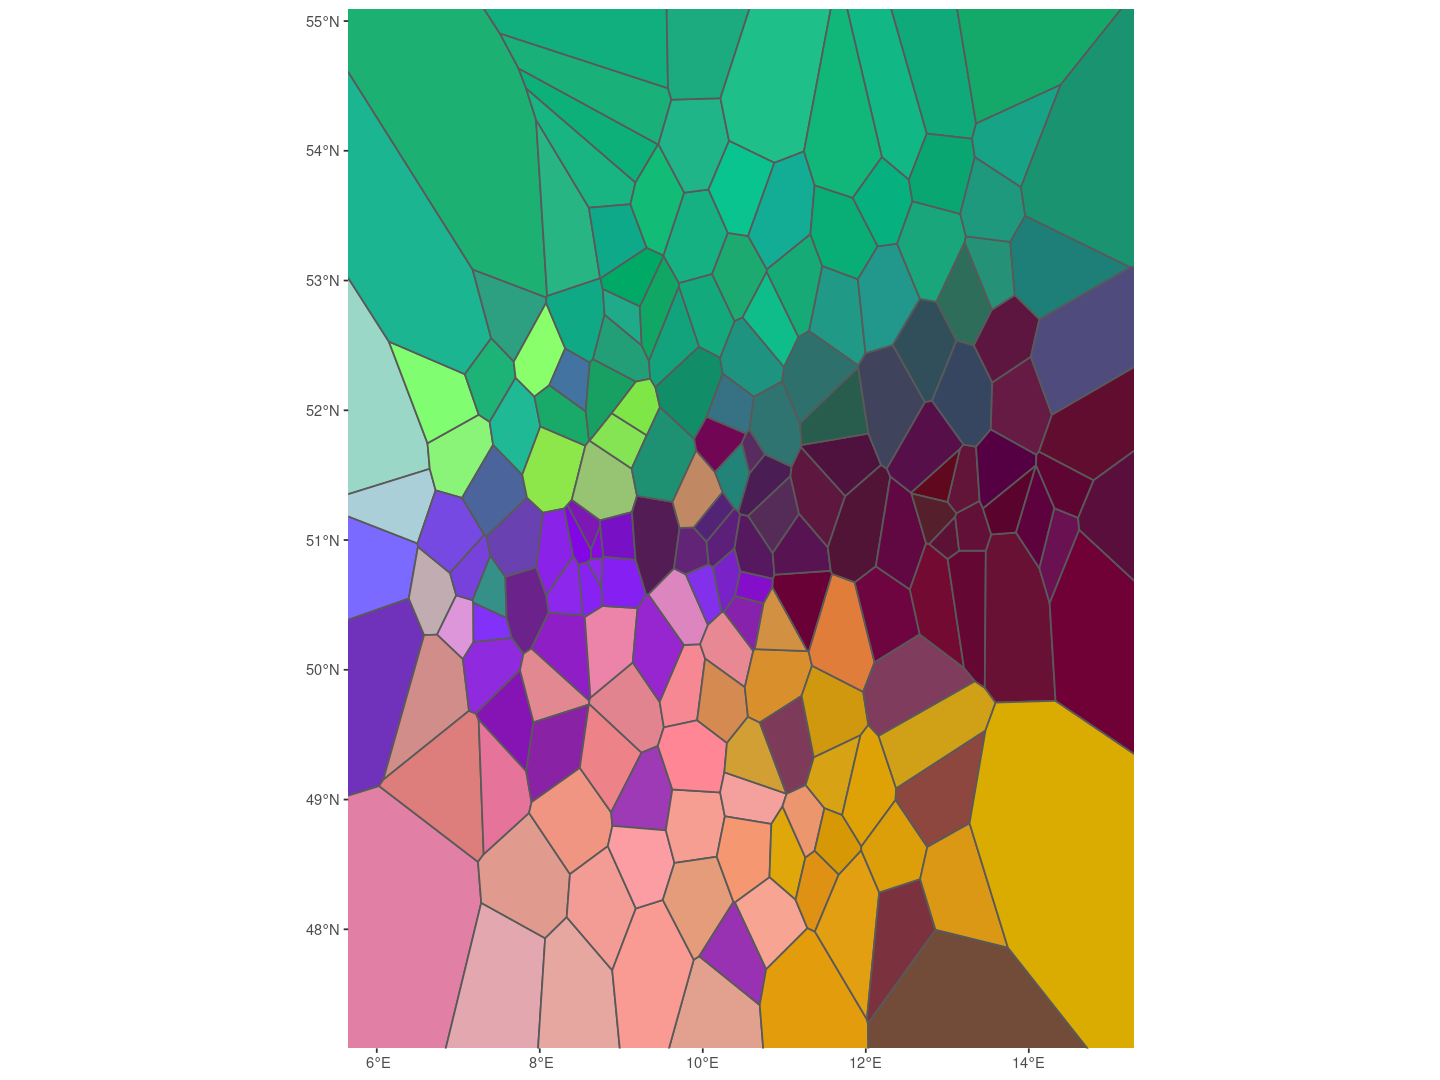

In [8]:
pad_voronoi %>%
    ggplot() +
    geom_sf(fill = pad_voronoi$col) +
    xlim(bb_pad$xmin, bb_pad$xmax) +
    ylim(bb_pad$ymin, bb_pad$ymax) 

We need to apply spatial intersection with a polygon representing the area of Germany.

In [9]:
germany_polygon <- read_sf("data/countries_world.kml") %>%
    filter(Name == "Germany") %>%
    st_geometry()

In [10]:
germany_polygon %>% write_sf("data/germany.kml")

In [11]:
germany_polygon %>%
    st_crs()

Coordinate Reference System:
  User input: WGS 84 
  wkt:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


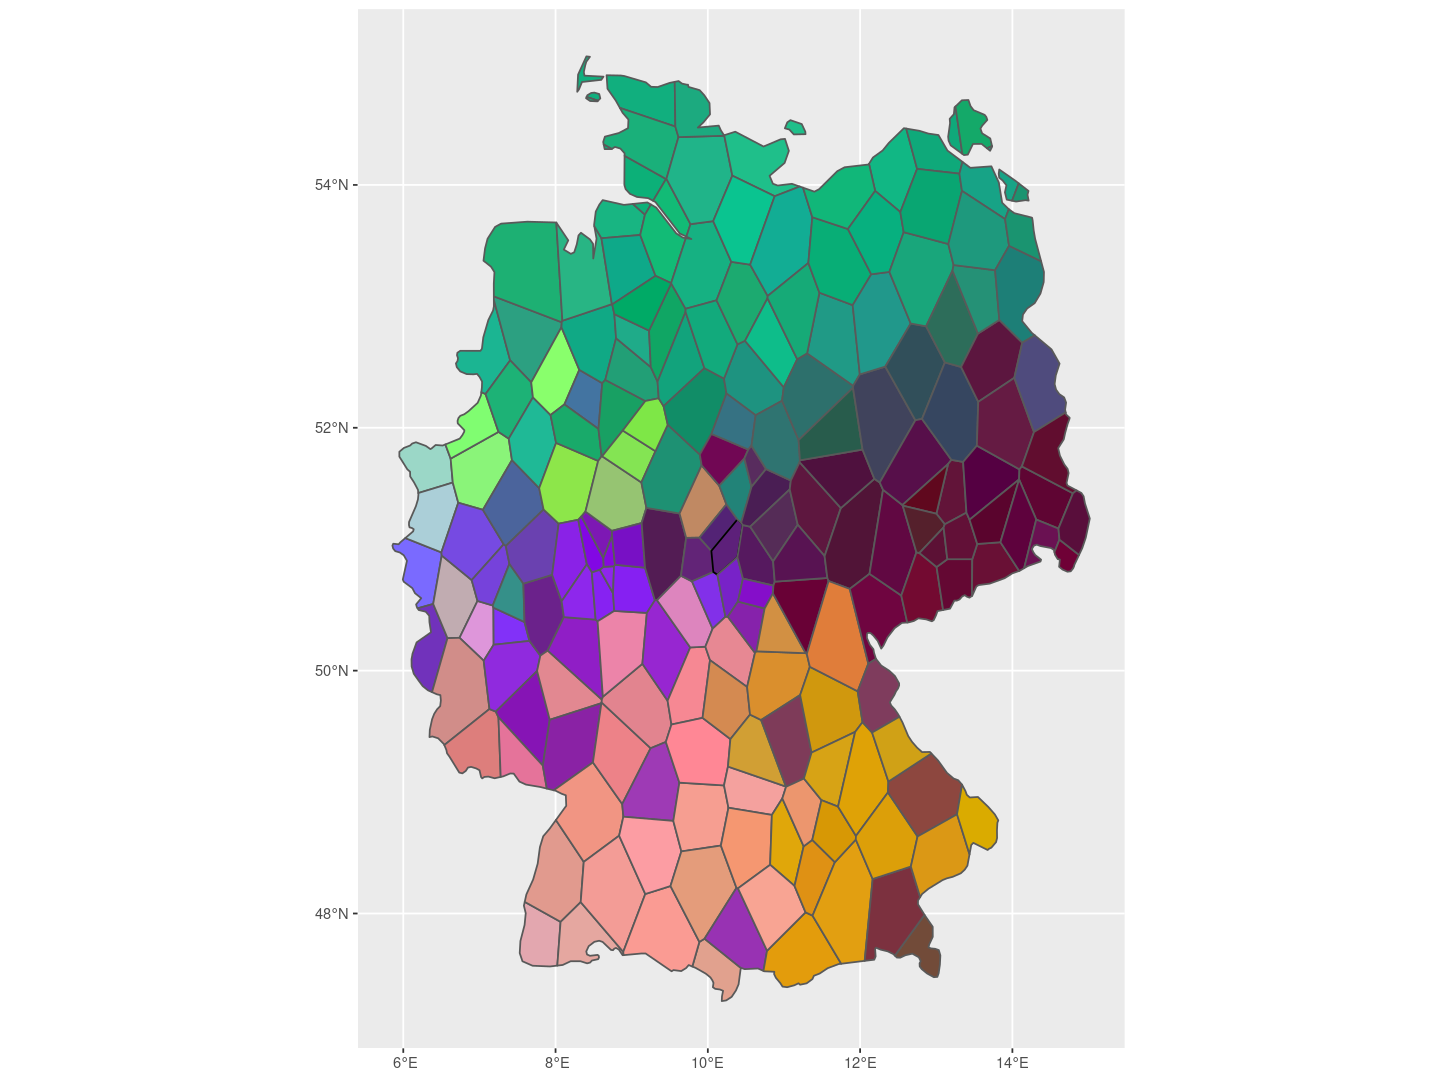

In [12]:
pad_voronoi <- pad_voronoi %>%
    st_intersection(germany_polygon) 

pad_voronoi %>%
    ggplot() +
    geom_sf(fill=pad_voronoi$col) 


In [13]:
pad_voronoi %>% 
    st_collection_extract() %>%
    select(doculect, col, r, g, b) %>%
    write_sf("data/pad_voronoi.shp")